# Задание 1 (7 баллов)
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs_torch.ipynb

На датасете lenta_sample.ru  дообучите две модели - modernbert-base (из семинара) и rumodernbert-base (https://huggingface.co/deepvk/RuModernBERT-base). Оцените разницу в качестве сравнив поклассовые метрики (classification_report)

Для обоих моделей качество должно быть >0.10 по f-мере (прогоните несколько экспериментов если у вас получаются нули, изменяя параметры).
Также для обоих моделей попробуйте дообучать модель и целиком и дообучать только последний слой.
Для RuModernBERT дополнительно сравните модель, которая использует первый вектор (cls токен, как в семинаре), так и усредненный вектор по всем hidden_state, который выдает bert.

### Подзадание на 1 балл
Дообучите любую из моделей, добавляя к BERT основе не только один линейный слой, но и один слой LSTM. Финальное состояние из этого слоя должно подаваться с новый линейный классификационный слой.

Примечание: так как обучение довольно долгое, я взяла половину от датасета.

### Общее для всех моделей

In [1]:
import torch
import pandas as pd
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from string import punctuation
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip

--2026-02-14 13:02:44--  https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/data/lenta_40k.csv.zip [following]
--2026-02-14 13:02:45--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/data/lenta_40k.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30658975 (29M) [application/zip]
Saving to: ‘lenta_40k.csv.zip’

lenta_40k.csv.zip   100%[===================>]  29.24M  --.-KB/s    in 0.05s   

2026-02-1

In [3]:
data = pd.read_csv('lenta_40k.csv.zip')
data.dropna(subset=['topic', 'text'], inplace=True)

texts = data["text"].values
labels = data["topic"].values

In [4]:
le = LabelEncoder()
labels = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.05, random_state=42, stratify=labels
)


X_train, X_test, y_train, y_test = X_train[:20_000], X_test[:1000], y_train[:20_000], y_test[:1000]

In [5]:
X_train[0], y_train[0]

('Бывший президент Тайваня Чень Шуйбянь, арестованный тайваньскими властями, был доставлен в больницу, сообщает France Presse со ссылкой на репортаж телеканала TVBS. Ранее адвокат Чень Шуйбяня заявил, что его клиент не прикасался к еде c 12 ноября, протестуя против решения суда о заключении его под стражу. Теперь врачам предстоит решить, необходимо ли подвергнуть Чень Шуйбяня принудительному кормлению. Свой арест экс-президент считает незаконным, а возбужденное против него дело прокуратурой - сфабрикованным нынешними властями Тайваня, которые заняли прокитайские позиции. Ожидается, что Чень Шуйбяня обвинят в растрате 450 тысяч долларов США, хотя пока официально это сделано не было. Ранее сообщалось, что экс-президента Тайваня также подозревают в коррупции, отмывании денег, взяточничестве и подделке документов. Его также подозревают в отмывании 21 миллиона долларов США, сообщает агентство DPA. Максимальный срок заключения, который грозит Чень Шуйбяню, - 30 лет тюрьмы. Согласно тайваньск

In [6]:
print(labels)
print(le.inverse_transform(labels))

[16 11  6 ... 15 11  3]
['Спорт' 'Мир' 'Интернет и СМИ' ... 'Силовые структуры' 'Мир'
 'Бывший СССР']


In [7]:
DEVICE = 'cuda'
MAX_LEN = 128

In [8]:
class LentaDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx])
        }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [9]:
from tqdm import tqdm

def train(model, iterator, optimizer, criterion, print_every=1000):

    model.train()
    epoch_loss = 0

    all_preds = []
    all_true = []

    for batch in tqdm(iterator, total=len(iterator)):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(labels.cpu().numpy())

    macro_f1 = f1_score(all_true, all_preds, average="macro")

    return epoch_loss / len(iterator), macro_f1

In [10]:
def evaluate(model, iterator, criterion):

    model.eval()
    epoch_loss = 0

    all_preds = []
    all_true = []

    with torch.no_grad():
        for batch in iterator:

            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(labels.cpu().numpy())

    macro_f1 = f1_score(all_true, all_preds, average="macro")

    return epoch_loss / len(iterator), macro_f1


In [11]:
import torch.nn as nn

class CLF(nn.Module):

    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель

        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(1)

    def forward(self, input_ids, attention_mask):
        hidden = self.pretrained_model(input_ids, attention_mask=attention_mask)[0]
        dense_outputs = self.fc(self.drop(hidden[:, 0]))
        outputs = self.act(dense_outputs)
        return outputs

In [12]:
def predict(model, iterator):
    preds = []
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)

            outputs = model(input_ids, attention_mask)
            batch_preds = torch.argmax(outputs, dim=1).cpu().numpy().tolist()
            preds.extend(batch_preds)

    return preds

### Модель 1 – modernbert-base (целиком)

In [11]:
from transformers import AutoTokenizer, AutoModel

model_name = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: answerdotai/ModernBERT-base
Key               | Status     |  | 
------------------+------------+--+-
head.dense.weight | UNEXPECTED |  | 
decoder.bias      | UNEXPECTED |  | 
head.norm.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [12]:
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LEN
)
val_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LEN
)

In [19]:
training_set = LentaDataset(train_encodings, y_train)
valid_set = LentaDataset(val_encodings, y_test)

training_generator = torch.utils.data.DataLoader(
    training_set,
    batch_size=128,
    shuffle=True,
    pin_memory=True,
    num_workers=4
)

valid_generator = torch.utils.data.DataLoader(
    valid_set,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=4
)


In [20]:
N_EPOCHS = 5

device = torch.device(DEVICE if torch.cuda.is_available() else 'cpu')
model = CLF(bert_model, len(set(labels)))
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)


f1s = []
f1s_eval = []

for epoch in range(N_EPOCHS):
    train_loss, train_f1 = train(model, training_generator, optimizer, criterion)
    print(f'EPOCH {epoch+1} TRAIN - mean f1 {train_f1}')
    f1s.append(train_f1)
    val_loss, val_f1 = evaluate(model, valid_generator, criterion)
    print(f'EPOCH {epoch+1} EVAL - f1 {val_f1}')
    f1s_eval.append(val_f1)


100%|██████████| 157/157 [01:53<00:00,  1.38it/s]

EPOCH 1 TRAIN - mean f1 0.21814821981263957


EPOCH 1 EVAL - f1 0.34376733012891025


100%|██████████| 157/157 [01:53<00:00,  1.38it/s]

EPOCH 2 TRAIN - mean f1 0.29417648200958785


EPOCH 2 EVAL - f1 0.4562327360984162


100%|██████████| 157/157 [01:53<00:00,  1.38it/s]

EPOCH 3 TRAIN - mean f1 0.3719595514209737


EPOCH 3 EVAL - f1 0.5317969920784843


100%|██████████| 157/157 [01:53<00:00,  1.38it/s]

EPOCH 4 TRAIN - mean f1 0.4407652176406717


EPOCH 4 EVAL - f1 0.5823536095228868


100%|██████████| 157/157 [01:53<00:00,  1.38it/s]

EPOCH 5 TRAIN - mean f1 0.49684455949498524


EPOCH 5 EVAL - f1 0.595583897007309


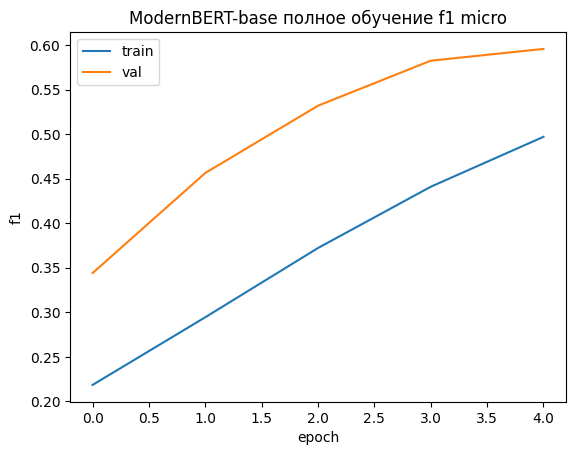

In [25]:
import matplotlib.pyplot as plt

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('ModernBERT-base полное обучение f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           2       0.67      0.33      0.44         6
           3       0.78      0.66      0.72        80
           4       0.84      0.50      0.63        32
           5       0.43      0.43      0.43        35
           6       0.55      0.50      0.53        62
           9       0.67      0.58      0.62        67
          11       0.62      0.77      0.69       182
          12       0.60      0.66      0.63        71
          13       0.50      0.54      0.52        13
          14       0.73      0.60      0.66       230
          15       0.29      0.42      0.34        19
          16       0.93      0.93      0.93        91
          17       0.39      0.70      0.50        10
          18       0.66      0.75      0.70       102

    accuracy                           0.67      1000
   macro avg       0.62      0.60      0.60      1000
weighted avg       0.68      0.67      0.67      1000



### Модель 1 – modernbert-base (заморозка)

In [13]:
from transformers import AutoTokenizer, AutoModel

model_name = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

for param in bert_model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: answerdotai/ModernBERT-base
Key               | Status     |  | 
------------------+------------+--+-
head.dense.weight | UNEXPECTED |  | 
head.norm.weight  | UNEXPECTED |  | 
decoder.bias      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [14]:
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LEN
)
val_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LEN
)

In [18]:
training_set = LentaDataset(train_encodings, y_train)
valid_set = LentaDataset(val_encodings, y_test)

training_generator = torch.utils.data.DataLoader(
    training_set,
    batch_size=16,
    shuffle=True,
    pin_memory=True,
    num_workers=2
)

valid_generator = torch.utils.data.DataLoader(
    valid_set,
    batch_size=16,
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

In [19]:
N_EPOCHS = 5

device = torch.device(DEVICE if torch.cuda.is_available() else 'cpu')
model = CLF(bert_model, len(set(labels)))
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)


f1s = []
f1s_eval = []

for epoch in range(N_EPOCHS):
    train_loss, train_f1 = train(model, training_generator, optimizer, criterion)
    print(f'EPOCH {epoch+1} TRAIN - mean f1 {train_f1}')
    f1s.append(train_f1)
    val_loss, val_f1 = evaluate(model, valid_generator, criterion)
    print(f'EPOCH {epoch+1} EVAL - f1 {val_f1}')
    f1s_eval.append(val_f1)


100%|██████████| 1250/1250 [03:44<00:00,  5.57it/s]

EPOCH 1 TRAIN - mean f1 0.07707233492396931


EPOCH 1 EVAL - f1 0.12803420199692592


100%|██████████| 1250/1250 [03:43<00:00,  5.60it/s]

EPOCH 2 TRAIN - mean f1 0.10691934656394689


EPOCH 2 EVAL - f1 0.1571182776113434


100%|██████████| 1250/1250 [03:42<00:00,  5.62it/s]

EPOCH 3 TRAIN - mean f1 0.12666511315929038


EPOCH 3 EVAL - f1 0.15066700470510783


100%|██████████| 1250/1250 [03:42<00:00,  5.61it/s]

EPOCH 4 TRAIN - mean f1 0.13713742883754693


EPOCH 4 EVAL - f1 0.17315925303106688


100%|██████████| 1250/1250 [03:43<00:00,  5.60it/s]

EPOCH 5 TRAIN - mean f1 0.14432612820273838


EPOCH 5 EVAL - f1 0.19284388812766504


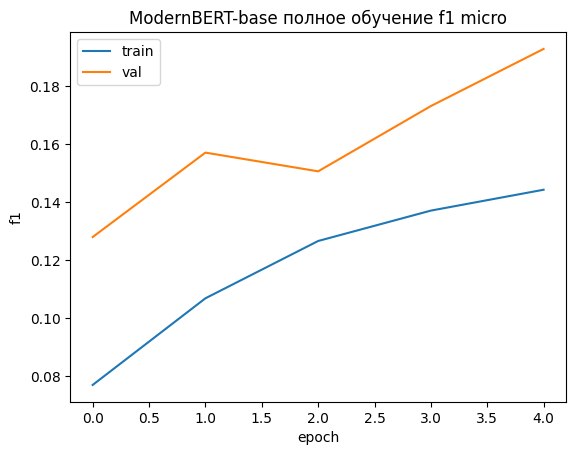

In [20]:
import matplotlib.pyplot as plt

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('ModernBERT-base f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

*простите, тут опечатка, которую чтобы править нужно заново код выполнять, но имелось в виду, конечно, обучение с заморозкой

In [21]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         6
           3       0.33      0.01      0.02        80
           4       1.00      0.03      0.06        32
           5       0.00      0.00      0.00        35
           6       1.00      0.05      0.09        62
           9       0.55      0.25      0.35        67
          11       0.39      0.52      0.45       182
          12       0.47      0.41      0.44        71
          13       0.00      0.00      0.00        13
          14       0.42      0.78      0.55       230
          15       0.00      0.00      0.00        19
          16       0.50      0.56      0.53        91
          17       0.00      0.00      0.00        10
          18       0.20      0.25      0.22       102

    accuracy                           0.40      1000
   macro avg       0.35      0.20      0.19      1000
weighted avg       0.42      0.40      0.34      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Модель 2 – rumodernbert-base (целиком)

In [13]:
from transformers import AutoTokenizer, AutoModel

model_name = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: deepvk/RuModernBERT-base
Key               | Status     |  | 
------------------+------------+--+-
head.norm.weight  | UNEXPECTED |  | 
decoder.bias      | UNEXPECTED |  | 
head.dense.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [14]:
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LEN
)
val_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LEN
)

In [15]:
training_set = LentaDataset(train_encodings, y_train)
valid_set = LentaDataset(val_encodings, y_test)

training_generator = torch.utils.data.DataLoader(
    training_set,
    batch_size=128,
    shuffle=True,
    pin_memory=True,
    num_workers=4
)

valid_generator = torch.utils.data.DataLoader(
    valid_set,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=4
)

In [17]:
N_EPOCHS = 5

device = torch.device(DEVICE if torch.cuda.is_available() else 'cpu')
model = CLF(bert_model, len(set(labels)))
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)


f1s = []
f1s_eval = []

for epoch in range(N_EPOCHS):
    train_loss, train_f1 = train(model, training_generator, optimizer, criterion)
    print(f'EPOCH {epoch+1} TRAIN - mean f1 {train_f1}')
    f1s.append(train_f1)
    val_loss, val_f1 = evaluate(model, valid_generator, criterion)
    print(f'EPOCH {epoch+1} EVAL - f1 {val_f1}')
    f1s_eval.append(val_f1)

100%|██████████| 157/157 [01:55<00:00,  1.36it/s]

EPOCH 1 TRAIN - mean f1 0.40444369384656104


EPOCH 1 EVAL - f1 0.6721173120491631


100%|██████████| 157/157 [01:55<00:00,  1.36it/s]

EPOCH 2 TRAIN - mean f1 0.5272883349156892


EPOCH 2 EVAL - f1 0.7295337215229261


100%|██████████| 157/157 [01:55<00:00,  1.36it/s]

EPOCH 3 TRAIN - mean f1 0.6224553555967112


EPOCH 3 EVAL - f1 0.7424833099514707


100%|██████████| 157/157 [01:55<00:00,  1.36it/s]

EPOCH 4 TRAIN - mean f1 0.7430223963561562


EPOCH 4 EVAL - f1 0.666833116756567


100%|██████████| 157/157 [01:55<00:00,  1.36it/s]

EPOCH 5 TRAIN - mean f1 0.8077471727829145


EPOCH 5 EVAL - f1 0.777301313811141


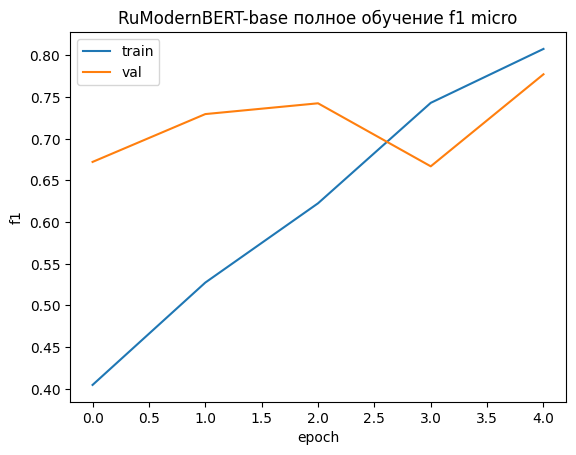

In [19]:
import matplotlib.pyplot as plt

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('RuModernBERT-base полное обучение f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           2       0.43      0.50      0.46         6
           3       0.84      0.90      0.87        80
           4       0.90      0.88      0.89        32
           5       0.76      0.54      0.63        35
           6       0.80      0.84      0.82        62
           9       0.81      0.93      0.86        67
          11       0.81      0.85      0.83       182
          12       0.82      0.79      0.81        71
          13       0.83      0.77      0.80        13
          14       0.84      0.82      0.83       230
          15       0.56      0.47      0.51        19
          16       0.96      0.93      0.94        91
          17       1.00      0.60      0.75        10
          18       0.88      0.87      0.88       102

    accuracy                           0.83      1000
   macro avg       0.80      0.76      0.78      1000
weighted avg       0.84      0.83      0.83      1000



### Модель 2 – rumodernbert-base (заморозка)

In [22]:
from transformers import AutoTokenizer, AutoModel

model_name = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

for param in bert_model.parameters():
    param.requires_grad = False

Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: deepvk/RuModernBERT-base
Key               | Status     |  | 
------------------+------------+--+-
head.norm.weight  | UNEXPECTED |  | 
decoder.bias      | UNEXPECTED |  | 
head.dense.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [23]:
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LEN
)
val_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LEN
)

In [26]:
training_set = LentaDataset(train_encodings, y_train)
valid_set = LentaDataset(val_encodings, y_test)

training_generator = torch.utils.data.DataLoader(
    training_set,
    batch_size=128,
    shuffle=True,
    pin_memory=True,
    num_workers=2
)

valid_generator = torch.utils.data.DataLoader(
    valid_set,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

In [27]:
N_EPOCHS = 15

device = torch.device(DEVICE if torch.cuda.is_available() else 'cpu')
model = CLF(bert_model, len(set(labels)))
optimizer = optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)


f1s = []
f1s_eval = []

for epoch in range(N_EPOCHS):
    train_loss, train_f1 = train(model, training_generator, optimizer, criterion)
    print(f'EPOCH {epoch+1} TRAIN - mean f1 {train_f1}')
    f1s.append(train_f1)
    val_loss, val_f1 = evaluate(model, valid_generator, criterion)
    print(f'EPOCH {epoch+1} EVAL - f1 {val_f1}')
    f1s_eval.append(val_f1)

100%|██████████| 157/157 [00:38<00:00,  4.03it/s]

EPOCH 1 TRAIN - mean f1 0.03181467531394817


EPOCH 1 EVAL - f1 0.07022971396387336


100%|██████████| 157/157 [00:38<00:00,  4.04it/s]

EPOCH 2 TRAIN - mean f1 0.04253688112623587


EPOCH 2 EVAL - f1 0.09274412349631915


100%|██████████| 157/157 [00:38<00:00,  4.04it/s]

EPOCH 3 TRAIN - mean f1 0.06409417182245909


EPOCH 3 EVAL - f1 0.10171857671949074


100%|██████████| 157/157 [00:38<00:00,  4.04it/s]

EPOCH 4 TRAIN - mean f1 0.0919628664778906


EPOCH 4 EVAL - f1 0.12852230685261157


100%|██████████| 157/157 [00:38<00:00,  4.04it/s]

EPOCH 5 TRAIN - mean f1 0.11222624710962543


EPOCH 5 EVAL - f1 0.14871642914889555


100%|██████████| 157/157 [00:38<00:00,  4.04it/s]

EPOCH 6 TRAIN - mean f1 0.13022010565544492


EPOCH 6 EVAL - f1 0.2058353905723004


100%|██████████| 157/157 [00:38<00:00,  4.04it/s]

EPOCH 7 TRAIN - mean f1 0.14596773830107046


EPOCH 7 EVAL - f1 0.1834946679788648


100%|██████████| 157/157 [00:38<00:00,  4.04it/s]

EPOCH 8 TRAIN - mean f1 0.15370857267595728


EPOCH 8 EVAL - f1 0.23861971116410713


100%|██████████| 157/157 [00:38<00:00,  4.05it/s]

EPOCH 9 TRAIN - mean f1 0.16188237138251893


EPOCH 9 EVAL - f1 0.2516638170222825


100%|██████████| 157/157 [00:38<00:00,  4.04it/s]

EPOCH 10 TRAIN - mean f1 0.1653396853794096


EPOCH 10 EVAL - f1 0.23341606742059065


100%|██████████| 157/157 [00:38<00:00,  4.04it/s]

EPOCH 11 TRAIN - mean f1 0.17776106331366026


EPOCH 11 EVAL - f1 0.25583746100306054


100%|██████████| 157/157 [00:38<00:00,  4.03it/s]

EPOCH 12 TRAIN - mean f1 0.18125829603282617


EPOCH 12 EVAL - f1 0.3088637348518533


100%|██████████| 157/157 [00:38<00:00,  4.05it/s]

EPOCH 13 TRAIN - mean f1 0.18448130952694172


EPOCH 13 EVAL - f1 0.31652771931746476


100%|██████████| 157/157 [00:38<00:00,  4.05it/s]

EPOCH 14 TRAIN - mean f1 0.1877526986629071


EPOCH 14 EVAL - f1 0.29253818630123757


100%|██████████| 157/157 [00:38<00:00,  4.03it/s]

EPOCH 15 TRAIN - mean f1 0.1929932029375144


EPOCH 15 EVAL - f1 0.307098546670657


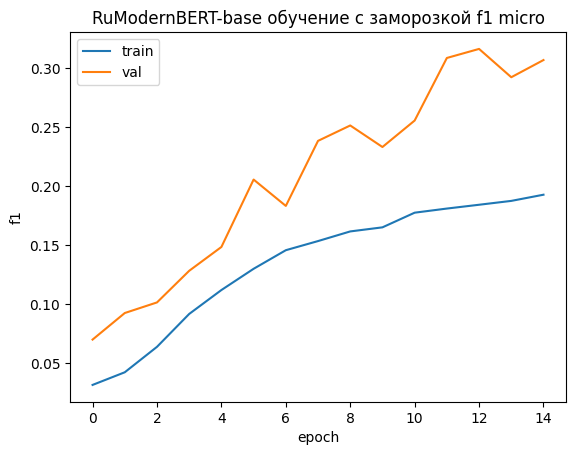

In [29]:
import matplotlib.pyplot as plt

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('RuModernBERT-base обучение с заморозкой f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         6
           3       1.00      0.01      0.02        80
           4       0.00      0.00      0.00        32
           5       0.00      0.00      0.00        35
           6       0.70      0.26      0.38        62
           9       0.76      0.48      0.59        67
          11       0.50      0.85      0.62       182
          12       0.75      0.42      0.54        71
          13       0.00      0.00      0.00        13
          14       0.50      0.90      0.65       230
          15       0.00      0.00      0.00        19
          16       0.97      0.80      0.88        91
          17       0.00      0.00      0.00        10
          18       0.64      0.60      0.62       102

    accuracy                           0.57      1000
   macro avg       0.42      0.31      0.31      1000
weighted avg       0.59      0.57      0.51      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Модель 2 – rumodernbert-base (усредненный вектор)

In [32]:
class CLFModified(nn.Module):

    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.pretrained_model = pretrained_model
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, attention_mask):
        hidden = self.pretrained_model(input_ids, attention_mask=attention_mask)[0]

        mask = attention_mask.unsqueeze(-1).float()
        pooled = (hidden * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)

        outputs = self.act(self.fc(self.drop(pooled)))
        return outputs

In [33]:
from transformers import AutoTokenizer, AutoModel

model_name = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: deepvk/RuModernBERT-base
Key               | Status     |  | 
------------------+------------+--+-
head.norm.weight  | UNEXPECTED |  | 
decoder.bias      | UNEXPECTED |  | 
head.dense.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [34]:
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LEN
)
val_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LEN
)

In [35]:
training_set = LentaDataset(train_encodings, y_train)
valid_set = LentaDataset(val_encodings, y_test)

training_generator = torch.utils.data.DataLoader(
    training_set,
    batch_size=128,
    shuffle=True,
    pin_memory=True,
    num_workers=4
)

valid_generator = torch.utils.data.DataLoader(
    valid_set,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=4
)

In [36]:
N_EPOCHS = 5

device = torch.device(DEVICE if torch.cuda.is_available() else 'cpu')
model = CLFModified(bert_model, len(set(labels)))
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)


f1s = []
f1s_eval = []

for epoch in range(N_EPOCHS):
    train_loss, train_f1 = train(model, training_generator, optimizer, criterion)
    print(f'EPOCH {epoch+1} TRAIN - mean f1 {train_f1}')
    f1s.append(train_f1)
    val_loss, val_f1 = evaluate(model, valid_generator, criterion)
    print(f'EPOCH {epoch+1} EVAL - f1 {val_f1}')
    f1s_eval.append(val_f1)

100%|██████████| 157/157 [01:55<00:00,  1.35it/s]

EPOCH 1 TRAIN - mean f1 0.412658497456526


EPOCH 1 EVAL - f1 0.68967781939652


100%|██████████| 157/157 [01:55<00:00,  1.35it/s]

EPOCH 2 TRAIN - mean f1 0.5387139646250266


EPOCH 2 EVAL - f1 0.7431368714250812


100%|██████████| 157/157 [01:55<00:00,  1.35it/s]

EPOCH 3 TRAIN - mean f1 0.61463677028644


EPOCH 3 EVAL - f1 0.7529872612913937


100%|██████████| 157/157 [01:55<00:00,  1.35it/s]

EPOCH 4 TRAIN - mean f1 0.7410132762902677


EPOCH 4 EVAL - f1 0.7258888013168615


100%|██████████| 157/157 [01:55<00:00,  1.35it/s]

EPOCH 5 TRAIN - mean f1 0.8259943542451891


EPOCH 5 EVAL - f1 0.7760742319169155


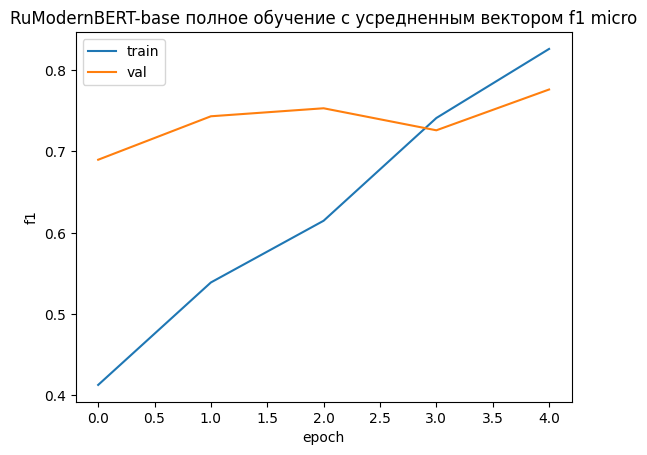

In [40]:
import matplotlib.pyplot as plt

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('RuModernBERT-base полное обучение с усредненным вектором f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           2       0.50      0.50      0.50         6
           3       0.83      0.93      0.88        80
           4       0.85      0.88      0.86        32
           5       0.67      0.69      0.68        35
           6       0.86      0.81      0.83        62
           9       0.89      0.82      0.85        67
          11       0.83      0.83      0.83       182
          12       0.80      0.89      0.84        71
          13       0.80      0.62      0.70        13
          14       0.84      0.85      0.84       230
          15       0.53      0.47      0.50        19
          16       0.96      0.95      0.95        91
          17       1.00      0.60      0.75        10
          18       0.88      0.84      0.86       102

    accuracy                           0.84      1000
   macro avg       0.80      0.76      0.78      1000
weighted avg       0.84      0.84      0.84      1000



### BERT + LSTM

In [43]:
class BertLSTMClassifier(nn.Module):
    def __init__(self, bert, n_classes, hidden_dim=256):
        super().__init__()
        self.bert = bert
        self.lstm = nn.LSTM(input_size=bert.config.hidden_size,
                            hidden_size=hidden_dim, batch_first=True,
                            bidirectional=False)
        self.classifier = nn.Linear(hidden_dim, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        sequence_output = outputs.last_hidden_state

        _, (hidden, _) = self.lstm(sequence_output)

        final_hidden = hidden[-1]
        return self.classifier(final_hidden)

In [44]:
from transformers import AutoTokenizer, AutoModel

model_name = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: deepvk/RuModernBERT-base
Key               | Status     |  | 
------------------+------------+--+-
head.norm.weight  | UNEXPECTED |  | 
decoder.bias      | UNEXPECTED |  | 
head.dense.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [45]:
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LEN
)
val_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LEN
)

In [46]:
training_set = LentaDataset(train_encodings, y_train)
valid_set = LentaDataset(val_encodings, y_test)

training_generator = torch.utils.data.DataLoader(
    training_set,
    batch_size=128,
    shuffle=True,
    pin_memory=True,
    num_workers=4
)

valid_generator = torch.utils.data.DataLoader(
    valid_set,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=4
)

In [47]:
N_EPOCHS = 5

device = torch.device(DEVICE if torch.cuda.is_available() else 'cpu')
model = BertLSTMClassifier(bert_model, len(set(labels)))
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)


f1s = []
f1s_eval = []

for epoch in range(N_EPOCHS):
    train_loss, train_f1 = train(model, training_generator, optimizer, criterion)
    print(f'EPOCH {epoch+1} TRAIN - mean f1 {train_f1}')
    f1s.append(train_f1)
    val_loss, val_f1 = evaluate(model, valid_generator, criterion)
    print(f'EPOCH {epoch+1} EVAL - f1 {val_f1}')
    f1s_eval.append(val_f1)

100%|██████████| 157/157 [01:57<00:00,  1.34it/s]

EPOCH 1 TRAIN - mean f1 0.17349270978245468


EPOCH 1 EVAL - f1 0.37316164177541566


100%|██████████| 157/157 [01:56<00:00,  1.34it/s]

EPOCH 2 TRAIN - mean f1 0.31951933965191764


EPOCH 2 EVAL - f1 0.4948328352533088


100%|██████████| 157/157 [01:57<00:00,  1.34it/s]

EPOCH 3 TRAIN - mean f1 0.42305869851349653


EPOCH 3 EVAL - f1 0.5829194083365907


100%|██████████| 157/157 [01:57<00:00,  1.34it/s]

EPOCH 4 TRAIN - mean f1 0.4644649140443505


EPOCH 4 EVAL - f1 0.6069146789522648


100%|██████████| 157/157 [01:56<00:00,  1.34it/s]

EPOCH 5 TRAIN - mean f1 0.4817938355039485


EPOCH 5 EVAL - f1 0.6016359192499469


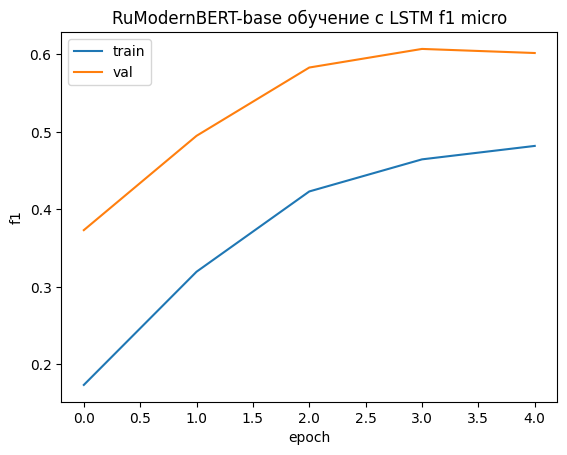

In [50]:
import matplotlib.pyplot as plt

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('RuModernBERT-base обучение с LSTM f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [51]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         6
           3       0.80      0.85      0.82        80
           4       0.76      0.88      0.81        32
           5       0.50      0.26      0.34        35
           6       0.93      0.60      0.73        62
           9       0.76      0.82      0.79        67
          11       0.78      0.83      0.81       182
          12       0.76      0.72      0.74        71
          13       0.00      0.00      0.00        13
          14       0.74      0.89      0.81       230
          15       0.00      0.00      0.00        19
          16       0.97      0.98      0.97        91
          17       0.78      0.70      0.74        10
          18       0.84      0.90      0.87       102

    accuracy                           0.79      1000
   macro avg       0.62      0.60      0.60      1000
weighted avg       0.76      0.79      0.77      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
